In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas  1.0.4
seaborn 0.10.1
numpy   1.18.4



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import shap

import pandas as pd
import requests

from io import StringIO

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [11]:
from collections import defaultdict

url = requests.get('https://docs.google.com/spreadsheets/d/1xqhFLsQplNUu5k9Uxv7DgTwftCiE78E0JmsKvNi0Ft4/export?format=csv')
csv_raw = StringIO(url.text)
df_truth = pd.read_csv(csv_raw)

inf_tax_file = "/mnt/btrfs/data/gtdb_95/gtdb_genomes_reps_r95/r95.gtdb.tax"

In [12]:
df_truth["results"] = 0

In [27]:
df_list = []

column_names = ["assembly_accession", "dataset", "query", "species"]


for t in df_truth.itertuples():
    query = t.homotypic_synonym
    results = !rg {query} {inf_tax_file}
    set_results = set()
    if len(results) > 0:
        for r in results:
            split = r.split("\t")
            set_results.add((split[0], ";".join(split[1].split(";")[:7])))
    queries = query.split("_")
    
    set_0 = !rg {queries[0]} {inf_tax_file}
    set_0 = set(set_0)
    set_1 = !rg {queries[1]} {inf_tax_file}
    set_1 = set(set_1)

    intersection = set_0.intersection(set_1)
    if len(intersection) > 0:
        for r in results:
            split = r.split("\t")
            set_results.add((split[0], ";".join(split[1].split(";")[:7])))
            
    for set_result in set_results:
        df_list.append((set_result[0], t.dataset, query, set_result[1]))
        
df_queries = pd.DataFrame(df_list, columns=column_names)

In [31]:
df_queries.groupby(["dataset", "query"]).size()

dataset        query                           
dual_index     Acinetobacter_baumannii             1
               Clostridium_beijerincki             3
               Cutibacterium_acnes                 1
               Deinococcus_radiodurans             1
               Enterococcus_faecalis               1
               Escherichia_coli                    3
               Helicobacter_pylori                 6
               Lactobacillus_gasseri               1
               Listeria_monocytogenes              3
               Neisseria_meningitidis              1
               Phocaeicola_vulgatus                1
               Pseudomonas_aeruginosa              2
               Staphylococcus_aureus               1
               Staphylococcus_epidermidis          1
               Streptococcus_agalactiae            1
               Streptococcus_mutans                1
               Streptococcus_pneumoniae            6
gis_20         Acinetobacter_baumannii             

# Building the true species dataset

In [101]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [";".join(_.split(";")[:7]) for _ in df_tax.tax]
df_tax["genus"] = [";".join(_.split(";")[:6]) for _ in df_tax.tax]
df_tax["family"] = [";".join(_.split(";")[:5]) for _ in df_tax.tax]

In [102]:
from glob import glob
import os

files = glob("/mnt/btrfs/data/type_1/species_mc/b6_split_by_sample/*.csv")

dfs = []
for file in files:
    name = '_'.join(os.path.basename(file).split('.')[:-2])
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_type_1_features = pd.concat(dfs)

In [103]:
rows = []
for t in df_type_1_features.itertuples():
    if t.assembly_accession in dd[t.dataset]:
        rows.append(True)
    else:
        rows.append(False)
df_type_1_features["truth"] = rows

In [104]:
df_type_1_features['truth'].sum()

198

In [109]:
mask_eubacterium = [_ in eubacteriums for _ in df_type_1_features['assembly_accession']]

In [111]:
df_type_1_features.groupby('dataset').mean()

,hits,percent_coverage,mean_coverage,sd_coverage,percent_padded_coverage,mean_padded_coverage,expected_percent_coverage,shannon_entropy,percent_max_uncovered_region,largest_pileup,gc_content,total_genome_length,ungapped_genome_length,num_n_groups,consecutive_ns,truth
dataset,,,,,,,,,,,,,,,,
dual_index,99.186609,0.001536,0.004886,0.052115,0.001993,0.006192,0.002993,0.010382,0.809869,4.460273,0.511798,4.119396e+06,4.107110e+06,80.974625,1485.071415,0.002136
gis_20,19253.052920,0.002234,0.586960,11.445821,0.002878,0.893255,0.106983,0.024168,0.746378,903.790394,0.530774,4.232701e+06,4.224509e+06,93.253547,968.163434,0.001753
hmp_even,1165.422709,0.002070,0.026119,0.671371,0.003497,0.073089,0.014671,0.018096,0.680443,90.556150,0.525590,4.102032e+06,4.091028e+06,103.687930,1168.463374,0.001569
hmp_staggered,652.053147,0.001033,0.012736,0.459527,0.002010,0.041127,0.008035,0.010263,0.702191,72.733790,0.525811,4.126146e+06,4.115047e+06,101.418378,1193.256750,0.001806
mbarc_26,6937.558789,0.002394,0.408469,1.163047,0.002622,0.382670,0.010724,0.019010,0.773166,52.282541,0.533281,4.196859e+06,4.182640e+06,95.470532,1634.145491,0.002147
zymo_even,559.568718,0.001024,0.026347,0.308280,0.001395,0.032079,0.008506,0.009897,0.794154,25.225523,0.514784,4.048984e+06,4.036996e+06,81.344104,1437.284874,0.000909
zymo_log,7514.998980,0.000722,0.234523,3.888986,0.001169,0.478779,0.037534,0.008298,0.796800,391.443404,0.515628,4.057524e+06,4.045588e+06,82.227224,1424.873245,0.000900


In [112]:
# df_type_1_features[~np.isfinite(df_type_1_features['shannon_entropy'])]

In [113]:
# df_type_1_features[~np.isfinite(df_type_1_features['percent_coverage'])]

In [114]:
X_type_1 = df_type_1_features
                                                 
X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
X_type_1 = X_type_1.dropna()

print(X_type_1.groupby('dataset').sum())

y = X_type_1["truth"]
X_type_1 = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth"])]


X_type_1_train, X_type_1_test, y_train, y_test = train_test_split(X_type_1, y, random_state=42)

                    hits  percent_coverage  mean_coverage    sd_coverage  \
dataset                                                                    
dual_index       1579150         24.456719      77.797533     829.716959   
gis_20         362361709         42.052061   11047.181289  215421.796525   
hmp_even        25248883         44.848096     565.878501   14545.256815   
hmp_staggered   13716590         21.731233     267.918649    9666.614768   
mbarc_26        93698669         32.331114    5516.780499   15708.117984   
zymo_even        9230086         16.898517     434.592579    5085.070763   
zymo_log       125214913         12.027565    3907.630176   64798.277804   

               percent_padded_coverage  mean_padded_coverage  \
dataset                                                        
dual_index                   31.736108             98.577615   
gis_20                       54.168344          16811.945440   
hmp_even                     75.773111           1583.47948

In [115]:
clf = RandomForestClassifier(random_state=42)

clf.fit(X_type_1_train, y_train)

RandomForestClassifier(random_state=42)

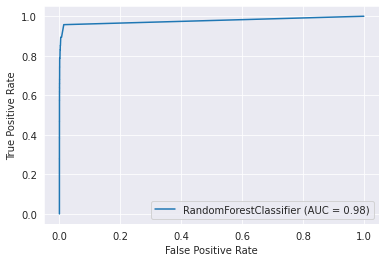

In [116]:
clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
plt.show()

In [ ]:
# X_type_1["truth"] = y
# sns.pairplot(X_type_1, hue="truth")

In [ ]:
# explainer = shap.TreeExplainer(clf, X_type_1_train)

# shap_values = explainer.shap_values(X_type_1_train)
# shap.summary_plot(shap_values, X_type_1_train, show=False)
# fig = plt.gcf()

In [117]:
y_preds = clf.predict(X_type_1)

accuracy = (y_preds == y).sum() / (y.shape[0])

print(accuracy)

0.9997824440397725


In [118]:
y_preds.sum()

181

In [119]:
y.sum()

198

In [120]:
# X_type_1 = df_type_1_features.loc[:, df_type_1_features.columns.difference(["shannon_entropy"])]
                                                 
# X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
# X_type_1 = X_type_1.dropna()

# print(X_type_1.groupby('dataset').sum())

In [121]:
df_type_1_features["dataset"].unique()

array(['dual_index', 'zymo_even', 'hmp_staggered', 'hmp_even', 'mbarc_26',
       'zymo_log', 'gis_20'], dtype=object)

In [122]:
X_type_1

,consecutive_ns,expected_percent_coverage,gc_content,hits,largest_pileup,mean_coverage,mean_padded_coverage,num_n_groups,percent_coverage,percent_max_uncovered_region,percent_padded_coverage,sd_coverage,shannon_entropy,total_genome_length,ungapped_genome_length
0,20,0.381278,0.296336,17764,41,0.480100,0.613951,263,0.286522,0.006250,0.351072,1.084750,1.319804,5786732,5781472
1,20,0.991119,0.328377,75106,79,4.723867,5.398296,1,0.917861,0.010597,0.946364,4.746405,3.603182,2782582,2782562
2,20,0.956147,0.322877,44393,74,3.126904,3.658072,1,0.841959,0.001599,0.892487,4.304550,3.153507,2427061,2427041
3,0,0.850406,0.388256,18880,61,1.899831,2.246275,0,0.413234,0.013428,0.511945,3.718532,2.404319,1680937,1680937
4,0,0.521883,0.387727,8131,39,0.737899,0.977603,0,0.227315,0.016710,0.322457,2.088014,1.422032,1663456,1663456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18816,20,0.000056,0.424080,1,1,0.000056,0.000154,52,0.000056,0.999944,0.000154,0.007451,0.000865,1296795,1295755
18817,20,0.000033,0.578566,1,1,0.000033,0.000095,267,0.000033,0.999967,0.000095,0.005758,0.000541,2111093,2105753
18818,20,0.000017,0.613526,1,1,0.000017,0.000048,25,0.000017,0.999983,0.000048,0.004080,0.000288,4204433,4203942
18819,94,0.000008,0.408442,1,1,0.000008,0.000022,135,0.000008,0.999992,0.000022,0.002789,0.000143,9000566,8997742


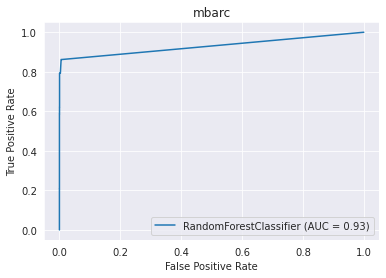

Precision: 0.75
Recall: 0.6923076923076923


In [177]:
# ra_mask = df_capitalist_species["relative_abundace"] > .005

# df_c_ra = df_capitalist_species[ra_mask]

for dataset in ["mbarc", "hmp", "gis", "dual_index", "zymo"]:
    
    X_type_1 = df_type_1_features
                                                 
    X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
    X_type_1 = X_type_1.dropna()
    
    mask_dataset = np.array([_.startswith(dataset) for _ in X_type_1["dataset"]])

    y = X_type_1["truth"]
    X_type_1 = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth"])]
    
    X_type_1_train = X_type_1.loc[~mask_dataset, :]
    X_type_1_test =  X_type_1.loc[mask_dataset, :]
    y_train = y.loc[~mask_dataset]
    y_test = y.loc[mask_dataset]
    
    df_train = df_type_1_features[~mask_dataset]
    df_test = df_type_1_features[mask_dataset]  
    
    clf = RandomForestClassifier(random_state=42)

    clf.fit(X_type_1_train, y_train)
    
    
    clf_disp = plot_roc_curve(clf, X_type_1_test, y_test)
    plt.title(dataset)
    plt.show()
    
    y_test_preds = clf.predict(X_type_1_test)
    
    precision = y_test[y_test_preds].sum() / y_test_preds.sum()
    
    print("Precision:", precision)
    
    recall = y_test[y_test_preds].sum() / df_truth["dataset"].str.startswith(dataset).sum()
    
    print("Recall:", recall)
    
    
    fps = y_test_preds & ~y_test
    
    aa_fps = df_test.loc[fps, "assembly_accession"]
    
    tps = y_test_preds & y_test
    
    aa_tps = df_test.loc[tps, "assembly_accession"]
    
    fns = ~y_test_preds & y_test
    
    aa_fns = df_test.loc[fns, "assembly_accession"]  
    break
    
#     mask_ra = df_c_ra["dataset"].str.startswith(dataset)
    
#     df_masked = df_c_ra.loc[mask_ra, :]
    
#     precision_cap = df_masked["truth"].sum() / df_masked.shape[0]
    
#     print("Precision Capitalist:", precision_cap)
    
#     recall_cap = df_masked["truth"].sum() / df_truth["dataset"].str.startswith(dataset).sum()
    
#     print("Recall Capitalist:", recall_cap)

In [178]:
fn_mask = [_ in set(aa_fns) for _ in df_tax["assembly_accession"]]
fn_tax = list(df_tax.loc[fn_mask, "species"].values)
fn_tax = sorted(fn_tax)
for _ in fn_tax:
    print(_)

k__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__Acidobacteriaceae;g__Terriglobus;s__Terriglobus_roseus_A
k__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__Acidobacteriaceae;g__Terriglobus;s__Terriglobus_roseus_B
k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium_glutamicum
k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Corynebacterium;s__Corynebacterium_glutamicum_A
k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Streptosporangiales;f__Streptosporangiaceae;g__Nocardiopsis;s__Nocardiopsis_dassonvillei
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus_pyogenes_A
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f

In [179]:
tp_mask = [_ in set(aa_tps) for _ in df_tax["assembly_accession"]]
tp_tax = list(df_tax.loc[tp_mask, "species"].values)
tp_tax = sorted(tp_tax)
for _ in tp_tax:
    print(_)

k__Archaea;p__Halobacteriota;c__Halobacteria;o__Halobacteriales;f__Natrialbaceae;g__Halovivax;s__Halovivax_ruber
k__Archaea;p__Halobacteriota;c__Halobacteria;o__Halobacteriales;f__Natrialbaceae;g__Natronobacterium;s__Natronobacterium_gregoryi
k__Archaea;p__Halobacteriota;c__Halobacteria;o__Halobacteriales;f__Natrialbaceae;g__Natronococcus;s__Natronococcus_occultus
k__Bacteria;p__Acidobacteriota;c__Acidobacteriae;o__Acidobacteriales;f__Acidobacteriaceae;g__Terriglobus;s__Terriglobus_roseus
k__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Segniliparus;s__Segniliparus_rotundus
k__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Atopobiaceae;g__Olsenella;s__Olsenella_uli
k__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Cytophagales;f__Cyclobacteriaceae;g__Echinicola;s__Echinicola_vietnamensis
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__Streptococcus_pyogenes
k__Bacteria;p__Firmic